<a href="https://colab.research.google.com/github/Imartinezcuevas/RL_MC_OL/blob/main/Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q-Learning

*Description:* Este notebook describe un experimento de aprendizaje por refuerzo utilizando el algoritmo de Q-Learning.
El propósito de este análisis es explicar la implementación del agente y probar con dos entornos (FrozenLake y Taxi) que funciona correctamente.

    Author: Iván Martínez Cuevas y Antonio Orenes Lucas
    Email: ivan.martinezc@um.es y antonio.orenesl@um.es
    Date: 2025/02/12

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html



# Introducción a Q-Learning

Q-learning es un algoritmo de aprendizaje por refuerzo off-policy que aprende una política óptima independientemente de la política que se esté siguiendo. Q-learning actualiza los valores Q utilizando la mejor acción posible en el siguiente estado, lo que lo hace más agresivo y eficiente en ciertos entornos.

## Componentes Clave
1. Agente (`Agent`, `TabularAgent`, `QLearningAgent`):
  * La clase `Agent` define la estructura general de un agente de RL.
  * `TabularAgent` espcecializa el agente para entornos con espacios de estados y acciones discretos, utilizando una tabla Q para almacenar los valores de acción.
  * `QLearningAgent` implementa el algoritmo Q-learning, actualizando los valores Q según la experiencia (estado, acción, recompensa, siguiente estado).

2. Política (`Policy`, `EpsilonGreedyPolicy`):
  * La clase `Policy` define la estructura general de una política.
  * `EpsilonGreedyPolicy` basada en la política usada en el ejemplo.
    * Política epsilon-soft: Se define una política donde todas las acciones tienen una probabilidad de ser elegida.
    * Política epsilon-greedy: basada en la política epsilon-soft. De esta forma el agente tiene una pequeña probabilidad de explorar (tomar una acción aleatoria) y una mayor probabilidad de explotar (tomar la acción que considera mejor). Esto permite equilibrar la exploración y la explotación.

3. Entorno (`gym.Env`):
  * El entorno de Gymnasium donde el agente interactua.
  * Los entornos probados son:
    * FrozenLake:  entorno de cuadrícula simple donde el agente debe navegar desde un punto de inicio hasta un punto de destino sin caer en agujeros.
    * Taxi: simula el escenario de un taxi que debe recoger a un pasajero en una de las ubicaciones posibles, llevarlo a su destino y dejarlo allí.

## Preparación del entorno
La preparación consta de las siguientes partes:

* **Instalación de Dependencias**: Se instalan las librerías necesarias para utilizar el entorno gymnasium para la simulación, con el objetivo de crear un ambiente controlado para que el agente pueda interactuar.

* **Importación de Librerías**: Se importan las bibliotecas necesarias como numpy para el manejo de matrices y matplotlib para la visualización de los resultados.

* **Importación de los entornos**: Se cargan dos versiones del entorno "FrozenLake": una de 4x4 y otra de 8x8. Ambas versiones no son resbaladizas, lo que facilita la comprensión de los resultados, dado que el entorno resbaladizo podría dificultar la comprensión inicial del aprendizaje. Además, se carga el entorno "Taxi-V3".

In [ ]:
#@title Copiar el repositorio.

!git clone https://github.com/Imartinezcuevas/RL_MC_OL.git
!cd k_brazos_MC_OL/

fatal: destination path 'RL_MC_OL' already exists and is not an empty directory.
/bin/bash: line 1: cd: k_brazos_MC_OL/: No such file or directory


In [ ]:
#@title Importamos todas las clases y funciones

%%capture
#@title Instalamos gym
!pip install 'gym[box2d]==0.20.0'

## Instalación de algunos paquetes.
#!apt-get update
## Para usar gymnasium[box2d]
#!apt install swig
#!pip install gymnasium[box2d]

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/RL_MC_OL/src')


# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
from typing import List
import random

from agentes import Agent, TabularAgent, QLearningAgent
from politicas import Policy, EpsilonGreedyPolicy
from plotting import plot_reward_ratio, plot_episode_lengths

seed_value= 100
random.seed(seed_value)
np.random.seed(seed_value)

In [ ]:
#@title Importamos escenarios
name = 'FrozenLake-v1'
env4 = gym.make(name, is_slippery=False, map_name="4x4", render_mode="ansi") # No resbaladizo para entender mejor los resultados.
env8 = gym.make(name, is_slippery=False, map_name="8x8", render_mode="ansi") # No resbaladizo para entender mejor los resultados.
env_taxi = gym.make('Taxi-v3', render_mode="ansi")

## Función de entrenamiento
Se ha modificado el bucle utilizado como referencia para poder usar los agentes desarrollados.

En resumen, la función `train_qlearning` simula múltiples episodios de interacción entre el agente y el entorno, actualizando el agente con cada transición y evaluando su rendimiento periódicamente.

In [ ]:
# Función de entrenamiento
def train_qlearning(agent, env, num_episodes=50000, decay=False, decay_alpha=False, max_step_per_episode=1000):
    evaluation_history = []
    step_display = num_episodes / 10

    for episode in tqdm(range(num_episodes)):
        state, info = env.reset(seed=100)
        agent.start_episode()  # Inicia el episodio para el agente

        done = False
        step = 0
        episode_reward = 0

        while not done and step < max_step_per_episode:
            # Obtiene la acción usando la política
            action = agent.get_action(state)

            # Ejecuta el paso en el entorno
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            # Actualiza el agente con la transición
            agent.update(state, action, next_state, reward, done, info)

            episode_reward += reward
            state = next_state  # Actualiza el estado
            step += 1

        # Guarda las estadísticas del episodio
        agent.end_episode(episode_reward, step)

        # Aplica el decaimiento de alpha al inicio de cada episodio
        if decay_alpha:
            agent.decay_learning_rate()

        # Si decay es verdadero, ajusta epsilon
        if decay:
            agent.policy.decay_epsilon()

        # Muestra la evolución cada cierto número de episodios
        if episode % step_display == 0 and episode != 0:
          success_rate, avg_length, avg_reward = evaluate_agent(agent, env, num_episodes=100)
          print(f"\nPorcentaje de éxito: {success_rate}, Longitud media del episodio: {avg_length}, Recompensa media: {avg_reward}")
          print(f"Epsilon actual: {agent.policy.epsilon:.4f}, alpha actual: {agent.alpha:.4f}")
          evaluation_history.append((episode, success_rate, avg_length, avg_reward))

    return agent

## Función de evaluación
La función `evaluate_agent` evalúa el rendimiento del agente ejecutando múltiples episodios con una política determinista (epsilon=0) y calcula métricas como la tasa de éxito, longitud promedio del episodio y recompensa promedio.

In [ ]:
def evaluate_agent(agent, env, num_episodes=100):
    success_count = 0
    episode_lengths = []
    total_rewards = []

    # Guardamos el valor original de epsilon
    original_epsilon = agent.policy.epsilon

    # Establecemos epsilon a 0 para evaluación determinista
    agent.policy.epsilon = 0.0

    for _ in range(num_episodes):
        state, _ = env.reset(seed=100)
        done = False
        steps = 0
        episode_reward = 0
        while not done:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            steps += 1
            episode_reward += reward
            state = next_state
            if terminated and reward > 0:
                success_count += 1
        episode_lengths.append(steps)
        total_rewards.append(episode_reward)

    # Restauramos el valor original de epsilon
    agent.policy.epsilon = original_epsilon

    success_rate = success_count / num_episodes
    avg_episode_length = np.mean(episode_lengths)
    avg_reward = np.mean(total_rewards)
    return success_rate, avg_episode_length, avg_reward

## FrozenLake - 4x4

FrozenLake 4x4 es un entorno que simula un lago congelado. Uno de las características clave de este entorno es que las recompensas son dispersas. Esto puede hacer que el agente tarde muchos episodios en recibir una recompensa positiva, lo que dificulta la actualización de la función de valor.

 11%|█         | 5422/50000 [00:08<00:18, 2410.09it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.3115, alpha actual: 0.2336


 21%|██        | 10319/50000 [00:10<00:25, 1528.26it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.2426, alpha actual: 0.1819


 31%|███       | 15440/50000 [00:12<00:13, 2655.44it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.1889, alpha actual: 0.1417


 41%|████      | 20418/50000 [00:14<00:11, 2554.12it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.1471, alpha actual: 0.1104


 51%|█████     | 25506/50000 [00:16<00:09, 2613.81it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.1146, alpha actual: 0.0859


 61%|██████    | 30295/50000 [00:17<00:07, 2676.94it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.0892, alpha actual: 0.0669


 71%|███████   | 35400/50000 [00:19<00:05, 2626.96it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.0695, alpha actual: 0.0521


 81%|████████  | 40359/50000 [00:22<00:04, 2056.00it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.0541, alpha actual: 0.0406


 91%|█████████ | 45533/50000 [00:23<00:01, 2731.84it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.0422, alpha actual: 0.0316


100%|██████████| 50000/50000 [00:25<00:00, 1963.84it/s]


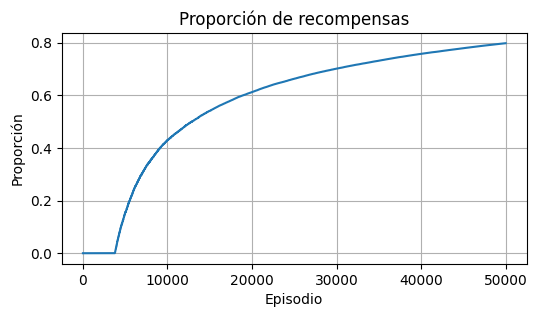

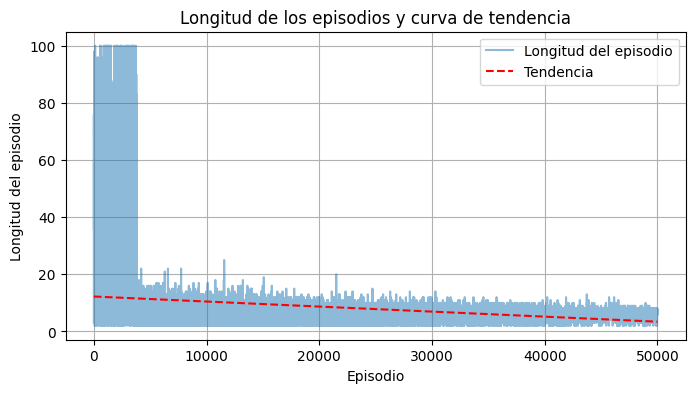

In [ ]:
# Crear la política con epsilon 0.4
epsilon_policy = EpsilonGreedyPolicy(env4.action_space, epsilon=0.4, epsilon_decay=0.99995, epsilon_min=0.01)

# Crear el agente usando MonteCarloOnPolicyAgent y la política
agent_env4 = QLearningAgent(env4, policy=epsilon_policy, alpha=0.3, gamma=1.0, alpha_decay=0.99995, alpha_min=0.01)

# Entrenamos al agente
trained_agent_env4 = train_qlearning(agent_env4, env4, num_episodes=50000, decay=True, decay_alpha=True)

stats = trained_agent_env4.stats()

# Graficamos los resultados
plot_reward_ratio(stats["reward_ratio"])
plot_episode_lengths(stats["episode_lengths"])

Las gráficas representan el proceso de aprendizaje del agente usando Q-Learning en el entorno FrozenLake 4x4.

* Primera gráfica:

    * Esta gráfica representa la proporción acumulada de recompensas obtenidas a lo largo del entrenamiento.

    * El agente comienza explorando y luego converge gradualmente hacia una mejor política.

    * Al final de los episodios, la proporción de recompensas es cercana a 0.8, lo que sugiere que el agente ha aprendido a completar la tarea de forma eficiente la mayoría de veces

* Segunda gráfica:

    * Representa la cantidad de pasos que el agente necesita para completar cada episodio.

    * Los episodios son muy largos al inicio, lo que indica exploración aleatoria y falta de conocimiento sobre la mejor ruta.

    * Se observa que la duración media de los episodios disminuye progresivamente. La línea de tendencia muestra una clara reducción en la cantidad de pasos por episodio, lo que confirma que el agente mejora con el tiempo.





In [ ]:
def pi_star_from_Q(env, Q):
    done = False
    pi_star = np.zeros([env.observation_space.n, env.action_space.n])
    state, info = env.reset(seed=100) # start in top-left, = 0
    actions = ""
    while not done:
        action = np.argmax(Q[state, :])
        actions += f"{action}, "
        pi_star[state,action] = action
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    return pi_star, actions

Q = trained_agent_env4.get_action_values()
pi, actions = pi_star_from_Q(env4, Q)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env4.render())
print()

Política óptima obtenida
 [[0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 0.]] 
 Acciones 1, 1, 2, 1, 2, 2,  
 Para el siguiente grid
   (Right)
SFFF
FHFH
FFFH
HFFG




## FrozenLake - 8x8

Con FrozenLake 8x8 aumentamos el espacio de estados. Mucho mayor que el de 4x4, 16 estados contra 64. Esto significa que el agente debe explorar un espacio más amplio para encontrar la ruta óptima.

Pero Q-Learning tiene una ventaja y es que off-policy, lo que significa que aprende la política óptima independientemente de la política de exploración. Lo que le permite converger más rápidamente que SARSA, especialmente en entornos deterministas o con baja estocasticidad.

Por eso hemos decido utilizar un epsilon no tan alto. Además, un valor de alfa moderado (0,2) permite que el agente actualice sus valores Q de manera significativa pero sin ser demasiado inestable.


 10%|█         | 5179/50000 [00:06<00:48, 922.59it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 1.0
Epsilon actual: 0.0164, alpha actual: 0.0164


 20%|██        | 10243/50000 [00:10<00:33, 1203.44it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 1.0
Epsilon actual: 0.0100, alpha actual: 0.0100


 30%|███       | 15187/50000 [00:14<00:29, 1187.38it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 1.0
Epsilon actual: 0.0100, alpha actual: 0.0100


 40%|████      | 20103/50000 [00:18<00:38, 768.21it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 1.0
Epsilon actual: 0.0100, alpha actual: 0.0100


 50%|█████     | 25220/50000 [00:22<00:20, 1209.95it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 1.0
Epsilon actual: 0.0100, alpha actual: 0.0100


 60%|██████    | 30157/50000 [00:26<00:15, 1307.05it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 1.0
Epsilon actual: 0.0100, alpha actual: 0.0100


 70%|███████   | 35092/50000 [00:30<00:20, 725.12it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 1.0
Epsilon actual: 0.0100, alpha actual: 0.0100


 80%|████████  | 40169/50000 [00:34<00:08, 1227.62it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 1.0
Epsilon actual: 0.0100, alpha actual: 0.0100


 90%|█████████ | 45194/50000 [00:37<00:03, 1227.21it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 1.0
Epsilon actual: 0.0100, alpha actual: 0.0100


100%|██████████| 50000/50000 [00:41<00:00, 1196.22it/s]


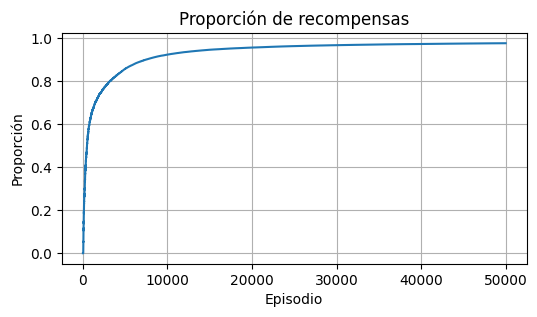

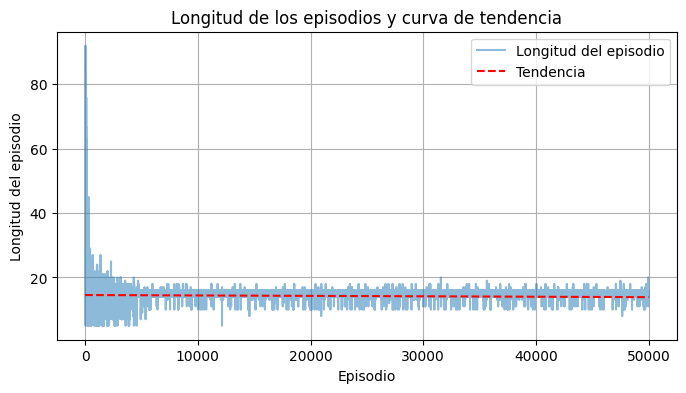

In [ ]:
# Crear la política con epsilon 0.4
epsilon_policy = EpsilonGreedyPolicy(env8.action_space, epsilon=0.2, epsilon_decay=0.9995, epsilon_min=0.01)

# Crear el agente usando MonteCarloOnPolicyAgent y la política
agentEnv8 = QLearningAgent(env8, policy=epsilon_policy, alpha=0.2, gamma=0.99, optimistic_init=True, init_value=1.0, alpha_decay=0.9995, alpha_min=0.01)

# Entrenamos al agente
trained_agent_env8 = train_qlearning(agentEnv8, env8, num_episodes=50000, decay=True, decay_alpha=True)

stats = trained_agent_env8.stats()

# Graficamos los resultados
plot_reward_ratio(stats["reward_ratio"])
plot_episode_lengths(stats["episode_lengths"])

Las gráficas representan el proceso de aprendizaje del agente usando Q-Learning en el entorno FrozenLake 8x8, lo que implica más estados y una tarea más compleja. 

* Primera gráfica:

    * Esta gráfica representa el porcentaje de episodios en los que el agente logra completar la tarea exitosamente.

    * Se observa que la curva de recompensas aumenta abruptamente al inicio, lo que indica que el agente está aprendiendo rápidamente. 

    * Después de los 10,000 episodios, la recompensa acumulada se acerca al 100%, lo que significa que el agente ha encontrado una política óptima y la sigue de manera confiable

* Segunda gráfica:

    * Representa la cantidad de pasos que el agente necesita para completar cada episodio.

    * Al inicio, el agente tiene episodios largos porque está explorando. Luego, la duración de los episodios se estabiliza entre 10 y 20 pasos, lo que indica que ha encontrado una ruta eficiente a la meta.





In [ ]:
Q = trained_agent_env8.get_action_values()
pi, actions = pi_star_from_Q(env8, Q)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env8.render())
print()

Política óptima obtenida
 [[0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 
 Acciones 2,

## Taxi

El entorno Taxi tiene un espacio de estados discreto pero complejo, definido por la ubicación del taxi, la ubicación del pasajero y el destino del pasajero.

El agente recibe recompensas por acciones correctas y penalizaciones por acciones incorrectas. Esto introduce un elemento que requiere que el agente evite acciones negativas.

Igual que en el ejemplo anterior utilizamos un epsilon bajo ya que Q-Learning aprende la polítca óptima independientemente de la política de exploración.

 10%|█         | 5164/50000 [00:05<00:45, 976.56it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.1103, alpha actual: 0.0736


 20%|██        | 10154/50000 [00:10<00:50, 784.48it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.0406, alpha actual: 0.0271


 30%|███       | 15225/50000 [00:14<00:32, 1058.95it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.0149, alpha actual: 0.0100


 40%|████      | 20143/50000 [00:19<00:26, 1147.87it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.0100, alpha actual: 0.0100


 50%|█████     | 25104/50000 [00:23<00:27, 902.17it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.0100, alpha actual: 0.0100


 60%|██████    | 30160/50000 [00:28<00:17, 1119.38it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.0100, alpha actual: 0.0100


 70%|███████   | 35173/50000 [00:32<00:14, 998.39it/s] 


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.0100, alpha actual: 0.0100


 80%|████████  | 40196/50000 [00:37<00:09, 1039.73it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.0100, alpha actual: 0.0100


 90%|█████████ | 45225/50000 [00:41<00:04, 1074.72it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.0100, alpha actual: 0.0100


100%|██████████| 50000/50000 [00:45<00:00, 1091.83it/s]


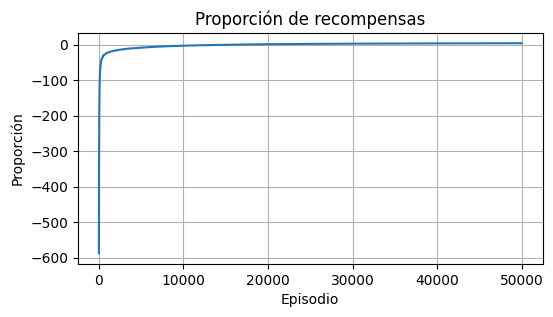

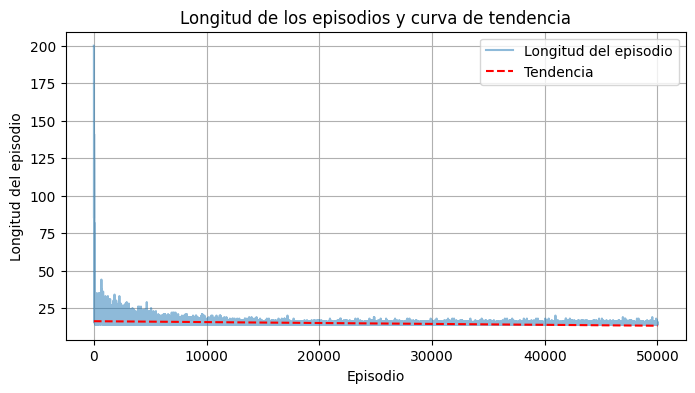

In [ ]:
# Crear la política con epsilon 0.4
epsilon_policy = EpsilonGreedyPolicy(env_taxi.action_space, epsilon=0.3, epsilon_decay=0.9998, epsilon_min=0.01)

# Crear el agente usando MonteCarloOnPolicyAgent y la política
agent_taxi = QLearningAgent(env_taxi, policy=epsilon_policy, alpha=0.2, gamma=0.95, alpha_decay=0.9998, alpha_min=0.01)

# Entrenamos al agente
trained_agent_taxi = train_qlearning(agent_taxi, env_taxi, num_episodes=50000, decay=True, decay_alpha=True)

stats = trained_agent_taxi.stats()

# Graficamos los resultados
plot_reward_ratio(stats["reward_ratio"])
plot_episode_lengths(stats["episode_lengths"])

Las gráficas representan el proceso de aprendizaje del agente usando Q-Learning en el entorno Taxi-v3.

* Primera gráfica:

    * Esta gráfica representa el porcentaje de episodios en los que el agente logra completar la tarea exitosamente.

    * Al inicio, la proporción de recompensas es muy negativa (~ -600), lo que significa que el agente está cometiendo muchos errores (probablemente haciendo movimientos innecesarios o dejando al pasajero en la ubicación incorrecta). Sin embargo, las recompensas suben rapidamente hacia 0, indicando que el agente está aprendiendo a minimizar errores.

    * A partir de 20,000 episodios, el agente parece haber aprendido una estrategia estable y su recompensa se mantiene cerca de 0.

* Segunda gráfica:

    * Representa la cantidad de pasos que el agente necesita para completar cada episodio.

    * En los primeros episodios, el agente tarda demasiado en completar la tarea (~200 pasos), lo que indica que está explorando el entorno sin saber exactamente qué hacer. Esto es normal en Taxi-v3, ya que hay muchos estados posibles y una mala acción puede extender la duración del episodio innecesariamente.

    * El agente empieza a aprender rutas más eficientes y los episodios se hacen más cortos en pocos episodios. A partir de los 20,000 episodios, la tendencia se estabiliza alrededor de 20-30 pasos por episodio, lo que indica que ha encontrado una estrategia efectiva.





In [ ]:
Q = trained_agent_taxi.get_action_values()
pi, actions = pi_star_from_Q(env_taxi, Q)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env_taxi.render())
print()

Política óptima obtenida
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]] 
 Acciones 1, 1, 2, 2, 2, 0, 0, 4, 1, 2, 1, 1, 1, 5,  
 Para el siguiente grid
 +---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


